In [1]:
# Utility
from tqdm.notebook import tqdm
import os

# Basic Math and data manipulation
import numpy as np
import pandas as pd 
import random

# Datetime object manipulation
from datetime import datetime as dt

# Data Visualization
import matplotlib.pyplot as plt

# Data preprocessing

# Machine learning model
import tensorflow as tf

# Model Evaluation
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error

# Parameter
PATH = 'Data/'
SEED = 2023
N_EPOCH = 100
TRAIN_SIZE = 0.85
DARK_THEME = 1
PLOT_SIZE = (17,7)

#Set Seed
np.random.seed(SEED)
random.seed(SEED)

# Set Plot Configuration
if DARK_THEME:
    plt.style.use('dark_background')
else:
    plt.style.use('seaborn-v0_8')

plt.rcParams['figure.figsize'] = PLOT_SIZE 

In [2]:
data = pd.read_excel(os.path.join(PATH, 'Data Inflasi.xlsx'), header=4)

data = data.iloc[-2::-1, :2] \
        .set_index('Periode')

In [3]:
train = data[:int(len(data)*TRAIN_SIZE)]
test = data[int(len(data)*TRAIN_SIZE):]

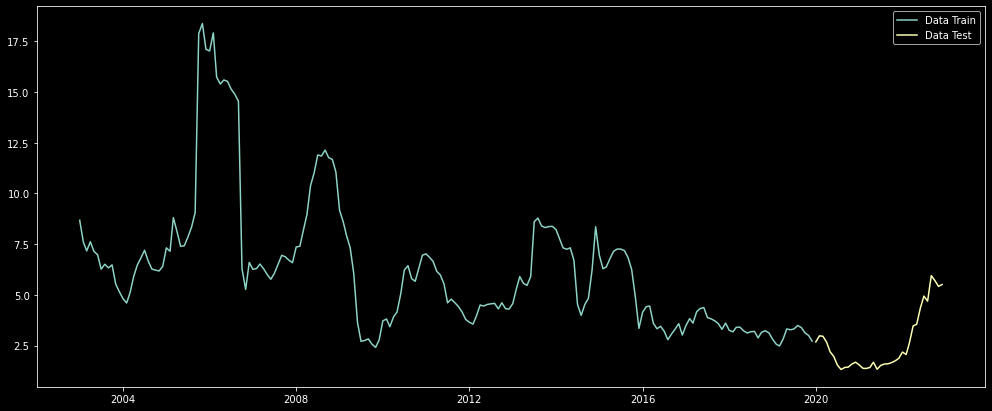

In [4]:
plt.plot(train, label='Data Train')
plt.plot(test, label='Data Test')
plt.legend()
plt.show()

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set = windowed_dataset(train, window_size=4, batch_size=32, shuffle_buffer=1000)
test_set = windowed_dataset(test, window_size=4, batch_size=32, shuffle_buffer=1000)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [16]:
optimizer = tf.keras.optimizers.Adam()

callback = tf.keras.callbacks.Callback()

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mape", "mae"])

In [17]:
history = model.fit(train_set,  
                    validation_data=test_set,
                    epochs=N_EPOCH,
                    callbacks=[callback],
                    verbose=0)

Epoch 1/1000
7/7 [==============================] - 4s 168ms/step - loss: 11.2711 - mape: 43.1795 - mae: 2.7742 - val_loss: 2.3019 - val_mape: 43.0684 - val_mae: 1.2015
Epoch 2/1000
7/7 [==============================] - 0s 12ms/step - loss: 10.2859 - mape: 40.5633 - mae: 2.6208 - val_loss: 2.0847 - val_mape: 39.9961 - val_mae: 1.1285
Epoch 3/1000
7/7 [==============================] - 0s 14ms/step - loss: 9.3138 - mape: 38.0763 - mae: 2.4656 - val_loss: 1.8839 - val_mape: 37.0123 - val_mae: 1.0571
Epoch 4/1000
7/7 [==============================] - 0s 13ms/step - loss: 8.4022 - mape: 35.5766 - mae: 2.3121 - val_loss: 1.6982 - val_mape: 34.2349 - val_mae: 0.9892
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 7.5845 - mape: 33.1740 - mae: 2.1632 - val_loss: 1.5300 - val_mape: 31.6676 - val_mae: 0.9254
Epoch 6/1000
7/7 [==============================] - 0s 13ms/step - loss: 6.8562 - mape: 30.8730 - mae: 2.0188 - val_loss: 1.3795 - val_mape: 29.3367 - val_mae: 0.

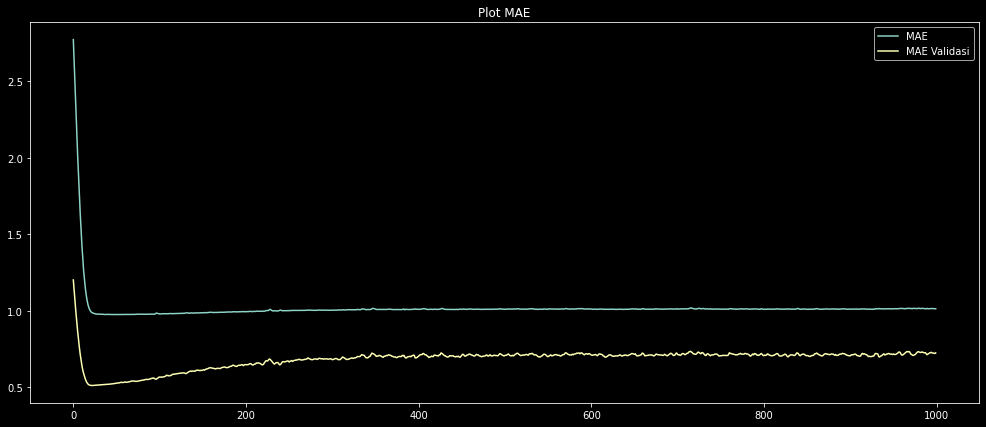

In [21]:
plt.title('Plot MAE')
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label = 'MAE Validasi')
plt.legend()
plt.show()

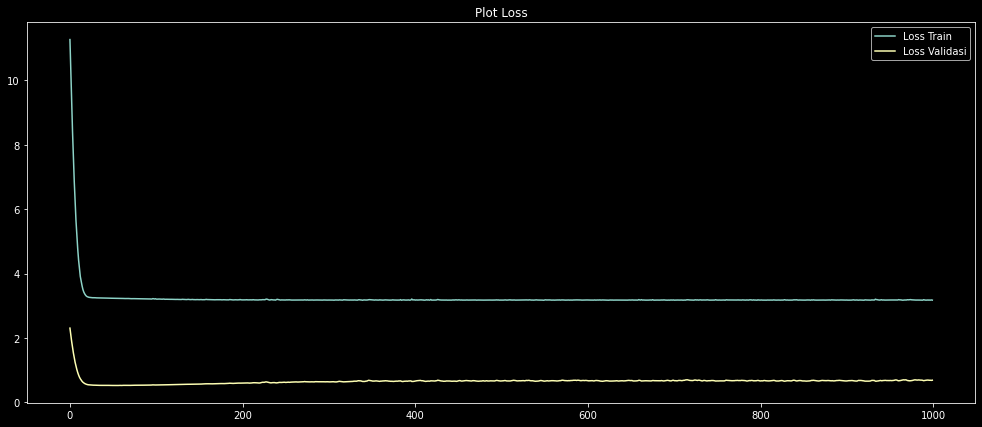

In [20]:
plt.title('Plot Loss')
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label = 'Loss Validasi')
plt.legend()
plt.show()

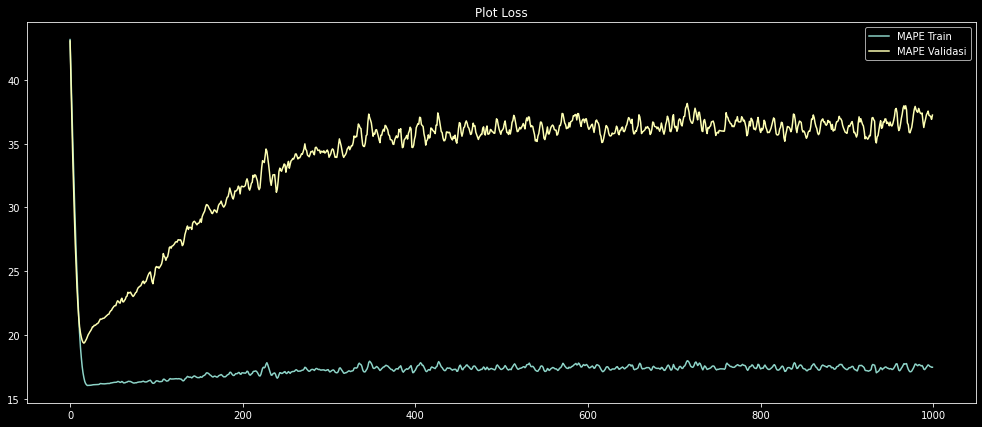

In [22]:
plt.title('Plot Loss')
plt.plot(history.history['mape'], label='MAPE Train')
plt.plot(history.history['val_mape'], label = 'MAPE Validasi')
plt.legend()
plt.show()

In [8]:
n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

In [9]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [7]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [8]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [9]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example


In [12]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


In [4]:
architecture = []
base = (5,5,5)
for i in range(-1,2):
    for j in range(-1,2):
        architecture.append([base[0]+i]*(len(base)+j))

In [6]:
def partition(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data) - sequence_length):
        x.append(data[i-sequence_length:i].values)
        y.append(data[i:i+1].values[0])
    
    x = np.array(x)
    y = np.array(y)
    return x, y

In [256]:
x_train = partition(24, train)[0]
y_train = partition(24, train)[1]
x_test = partition(24, test)[0]
y_test = partition(24, test)[1]

In [257]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(36, activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(24, activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(12, activation='relu', kernel_initializer='he_uniform'),
  tf.keras.layers.Dense(1),
])

In [258]:
optimizer = tf.keras.optimizers.Adam()

callback = tf.keras.callbacks.Callback()

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=["mape", "mae"])

In [259]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=[x_test, y_test],
                    epochs=N_EPOCH,
                    callbacks=[callback],
                    verbose=0)

In [261]:
def forecast(model, last_data, n):
    y = []
    for i in range(n):
        pred = model.predict(last_data)
        last_data = np.append(last_data[:,1:], pred).reshape(-1,24)
        y.append(pred)
    return y

In [262]:
y_pred = np.array(forecast(model, x_train[-1].reshape(-1,24), len(test)))

1/1 [==============================] - 0s 33ms/step


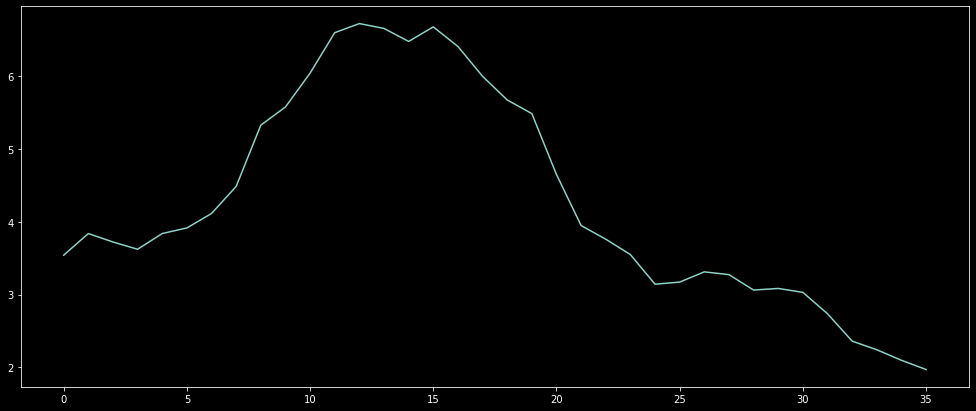

In [263]:
plt.plot(y_pred.transpose(1,-1,0)[0][0])

In [264]:
y_pred = y_pred.transpose(1,-1,0)[0][0]

In [265]:
mean_squared_error(test, y_pred)

10.252539303287131

In [241]:
len(test)

36